# CMPE257 Project1: E-mail Autocomplete Project

#### Yuhua He - Data preparation, preprocessing(tf-idf), K-means algorithm, Elbow method
#### Yuanzhe Li - Finding business model, preprocessing(stemming), Testing
#### Samuel Yang - Data prepraration, Documentation, preprocessing(feature extraction), Testing

### What story is the data telling us?

#### In this group assignment, the business objective we are focusing on, is the "Smart Email Compose" project. We are using the Enron email dataset, which has the "file" column and "message" column, after servel feature extracting process, we can extract more features like "file name", "message body", from", "to", "message id". So, the data is basically show what we need. It provides several thousands of messages body with completely different structure. For example, some of the messages greeting messgae that comes up with the "hello" word frequently, and some don't. In order to recognize it, we try to apply the tf-tdf technique to find out the frequency of each words. 

### What business problem can be solved using the data?

#### From what we do and trying to processing the data, "Content Discovery" can be solved easily. After we appliedK-means cluserting algorithm, we can divided all the data into several clusters where has similar words. More importantly, by applying machine-learning algorithm, we can further categorized emails into 4 major groups, which is am essential observation for our project. We also apply the eblow method to interprete and validate the consistency within cluster analysis designed to find appropriate amount of clusters we need in this situation.

In [16]:
#import Library

import email, re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import  LatentDirichletAllocation
from scipy.spatial.distance import cdist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

## Strong initial dataset (Enron Email Dataset):

In [17]:
# Read the data into a DataFrame
emails_enrich_df = pd.read_csv('rdany_conversations_2016-03-01.csv')
emails_df = pd.read_csv('emails.csv',nrows = 30000, error_bad_lines = False)
print(emails_enrich_df.shape, emails_df.shape)

(6325, 5) (30000, 2)


## Data Enrichment (Coversation Dataset):

In [18]:
emails_enrich_df.head()

,source,text,date,hashed_message_id,hashed_chat_id
0,human,[START],0,fce1649c457fcd02600f0f1aece46c1a88d3258fdfc2d8...,b71a7a6e3eae414113fd7c6d3fc3e13b50fd5fbf335b95...
1,robot,"Hi there, how are you!? 😁😁",23789,8601139615d43330986f3f27b78bcf0212d2a4f1e4a4d7...,b71a7a6e3eae414113fd7c6d3fc3e13b50fd5fbf335b95...
2,human,"Oh, thanks! I'm fine. This is an evening in my...",41177,a2eb7031aa536c89231517fc71ea3315c89ca50fef155b...,b71a7a6e3eae414113fd7c6d3fc3e13b50fd5fbf335b95...
3,robot,😄 here is afternoon!,41598,e0ac851c9ff34cd39a7e490fb9021163b8be6df097737f...,b71a7a6e3eae414113fd7c6d3fc3e13b50fd5fbf335b95...
4,human,How do you feel today? Tell me something about...,41629,0d2937ef1d5e806d46b78f2264bee44f9cbad0d68e4ce2...,b71a7a6e3eae414113fd7c6d3fc3e13b50fd5fbf335b95...


In [19]:
#Helper functions

def get_email_text(email):
    '''To get the content from email objects'''
    email_contents = []
    for email_object in email.walk():
        if email_object.get_content_type() == 'text/plain':
            email_contents.append(email_object.get_payload())
    return ''.join(email_contents)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

## Preprocessing:

In [20]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)

# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]

# Parse content from emails
emails_df['content'] = list(map(get_email_text, messages))

#rename
emails_enrich_df = emails_enrich_df.rename(index = str, columns = {"text" : "content"})

enriched_df = emails_df['content'].append(emails_enrich_df['content'], ignore_index = True).copy()

#emails_df['content'].to_csv('content.csv', index = False, header = True)
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)

#print

In [21]:
print(enriched_df.size)
enriched_df.head()
enriched_df=enriched_df.to_frame()

36325


In [22]:
#Helper function - Removing stop words, removel unimpotant words.

def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(('fwd','RE','FW','Hello','Meeting','Ga','Access','positions','list','forward','floor','collar','fixed',
    'enron','hou','ect','corp','please','vince','time','mail','john','kay','day','message','week','kaminski','year',
    'meeting','enronxgate','question','group','work','call','scott','change','company','let','mann','date','number',
    'mark','today','david','mike','issue','houston','chris','subject','way','bass','jeff','edu','office','doc','don',
    'month','copy','name','comment','email','need','phone','point','thing','request','look','ben','michael','list',
    'help','delainey','fax','morning','use','tomorrow','thank','phillip','hotmail','guy','robert','night','lon',
    'part','talk','kate','home','mailto','person','address','form','jeffrey','something','end','line','hour',
    'place','march','love','anything','paul','giron','smith','hope','darron','jim','kevin','weekend','george',
    'north','someone','section','richard','discus','bob','jacoby','ena','room','see','demand','desk','area',
    'everyone','greg','detail','jason','afternoon','discussion','tom','kslaw','check','basis','visit','mcconnell',
    'miller','entity','location','peter','monday','response','show','page','jennifer','lot','meet','respond',
    'yesterday','pdx','house','june','larry','jan','dan','city','july','judy','friday','julie','shirley','meter',
    'level','fyi','addition','martin','anyone','generation','department','type','rick','friend','period','word',
    'lisa','think','class','johnson','org','robin','thompson','columbiagas','didn','april','william','lee','thomas',
    'hey','adam','stephen','man','sender','tim','taylor','organization','center','everything','ferc','notice',
    'start','davis','york','sorry','cell','return','street','hernandez','thursday','campbell','care','content',
    'curve','minute','floor','stinson','janet','head','move','kind','kent','tuesday','sheila','send','suzanne',
    'brenda','kim','matter','fgt','carolyn','cindy','ccampbell','tell','fwd','crenshaw','baumbach','linda','side',
    'clark','mind','hain','wharton','future','errol','carlos','hand','matt','bruce','gossett','brian','try',
    'wednesday','calendar','laura','nothing','doug','llc','rebecca','rob','stephanie','austin','victor','join',
    'joseph','couple', 'allen', 'kean', 'arnold', 'var', 'keith', 'lucy', 'grigsby','com', 'cc', 'pm', 'http',
    'market','size', 'image', 'td', 'align', 'font','www', 'gas' ,'send', 'original', 'pt','tr','send','br','k','f','b' ))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word, pos='v') for word in punc_free.split())
    
    return normalized

In [23]:
enriched_df.reindex()
enriched_df.head()

,content
0,Here is our forecast\n\n
1,Traveling to have a business meeting takes the...
2,test successful. way to go!!!
3,"Randy,\n\n Can you send me a schedule of the s..."
4,Let's shoot for Tuesday at 11:45.


In [24]:
#enriched_df[enriched_df.index.duplicated()]
#enriched_df = pd.DataFrame({"index": enriched_df.index, "content" : enriched_df.values})
type(enriched_df)

pandas.core.frame.DataFrame

In [25]:
#Drop rows have too less words
enriched_df = enriched_df[enriched_df['content'].apply(lambda x: len(x.split()) > 10)]
print(enriched_df.shape)

(28945, 1)


## Bag of Words Model

### BoW is a really useful model for the data-preparation process especially for text data. 

In [26]:
#cleaning all numeric data
enriched_df = enriched_df.replace('\d+', 'NUM', regex=True)

#initialize the Vectorizer
count_vec = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")

# learn the vocab and parse them as features based on the given params.
count_occurs = count_vec.fit_transform(enriched_df['content'].apply(clean))

# printing first hundred features
print(count_vec.get_feature_names()[:100])

['ability', 'able', 'accept', 'access', 'accord', 'account', 'across', 'act', 'action', 'active', 'activities', 'activity', 'actually', 'ad', 'add', 'additional', 'administration', 'advance', 'advise', 'affiliate', 'agent', 'ago', 'agree', 'agreement', 'ahead', 'air', 'airlines', 'al', 'allow', 'along', 'already', 'also', 'although', 'always', 'america', 'american', 'among', 'amount', 'analysis', 'analyst', 'analysts', 'anderson', 'andrew', 'andy', 'ankle', 'announce', 'another', 'answer', 'anum', 'aol', 'appear', 'application', 'applications', 'apply', 'appreciate', 'approach', 'appropriate', 'approval', 'approve', 'areas', 'arial', 'around', 'article', 'ask', 'asp', 'assets', 'associate', 'assume', 'attach', 'attempt', 'attend', 'auction', 'audit', 'august', 'available', 'average', 'away', 'back', 'bad', 'balance', 'ball', 'bank', 'barry', 'base', 'baughman', 'bay', 'bear', 'beck', 'become', 'begin', 'behind', 'believe', 'benefit', 'best', 'bestfares', 'beth', 'better', 'bgcolor', 'b

In [27]:
count_occur_df = pd.DataFrame((count, word) for word, count in zip(count_occurs.toarray().tolist()[0], count_vec.get_feature_names()))

count_occur_df.columns = ['Word', 'Count']
count_occur_df.sort_values('Count', ascending=False, inplace=True)
print(count_occur_df.head(10))

           Word  Count
537        meet      4
125    business      4
883        take      3
928        trip      3
990       would      3
407        hold      2
305        even      2
300  especially      1
766       round      1
963        wait      1


## Linear Regression (with BoW model):

#### In order to perform linear regression model, besides combining with BoW, we also need to use LabelEncoder to convert string to numeric data

In [28]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
X = le.fit(count_occur_df['Word']).transform(count_occur_df['Word'])
y = count_occur_df['Count']
print(X.shape)
print(y.shape)

(1000,)
(1000,)


In [29]:
#Data Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

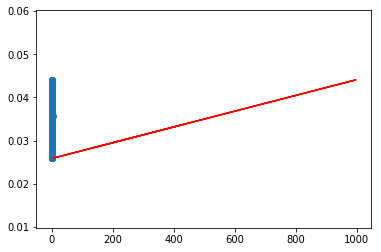

In [30]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train[:, None],y_train)

predictions = lm.predict(X_test[:, None])
plt.scatter(y_test,predictions)

plt.plot(X_test, predictions,color='red')
plt.show()

#### From the graph above we can see the words basically will all be like the "here", "is", "our", etc. Those words comes out frequently as a comparison to other words, so it will be useful for us to making a predictions that those words will more likely to appear after several patterns.

## Decision Tree:

In [31]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [40]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train[:, None],y_train)
y_pred = dt.predict(X_test[:, None])

### Evaluating the Decision Tree model:

In [69]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9275


#### The this model gives us a 92.75% accuracy, which is a really high accuracy. But, there's a chance of being "overfitting" since we only use the Hold-out Validation. To furthermore test the model's performance, we should use Cross-Validation just in case.

### Cross-Validation (for Decision Tree Model):

In [76]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt, X[:,None], y, cv=10)
print("CV scores mean: {}".format(scores.mean()))

CV scores mean: 0.584775703605629


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


#### From the mean of the CV scores above, we can conclude that the model is overfitting. To prevent overfitting in the Decision Tree Model, "Pruning" is a really good way to start with.

### Pruning (Prevent Overfitting for Decision Tree Model):

In [71]:
dt_after_pruning = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=10, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')

In [72]:
dt_after_pruning = dt_after_pruning.fit(X_train[:, None],y_train)
y_pred2 = dt_after_pruning.predict(X_test[:, None])
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Accuracy: 0.95


#### The accuracy seems pretty high, lets futhremore move on to the Cross-Validaion. 

In [77]:
scores = cross_val_score(dt_after_pruning, X[:,None], y, cv=10)
print("CV scores mean: {}".format(scores.mean()))

CV scores mean: 0.9652165767795324


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


#### After pruning, the mean of CV-scores comes to 0.96 which is really high and it also shows that the Decision Tree model is really accurate in this case. As it is really useful for us to classify the text data into categories based on the word counts. 

In [73]:
#Data cleaning, removing stop words

analysis_df=emails_df[['From', 'To', 'Date','content']].dropna().copy()
analysis_df = analysis_df.loc[analysis_df['To'].map(len) == 1]
analysis_df["clean_content"]=analysis_df.content.apply(clean)
analysis_df["clean_content"].to_csv('clean_c.csv', index = False, header = True)
analysis_df.head()

,From,To,Date,content,clean_content
Message-ID,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,(phillip.allen@enron.com),(tim.belden@enron.com),2001-05-14 23:39:00,Here is our forecast\n\n,forecast
<15464986.1075855378456.JavaMail.evans@thyme>,(phillip.allen@enron.com),(john.lavorato@enron.com),2001-05-04 20:51:00,Traveling to have a business meeting takes the...,travel business take fun trip especially prepa...
<24216240.1075855687451.JavaMail.evans@thyme>,(phillip.allen@enron.com),(leah.arsdall@enron.com),2000-10-18 10:00:00,test successful. way to go!!!,test successful go
<13505866.1075863688222.JavaMail.evans@thyme>,(phillip.allen@enron.com),(randall.gay@enron.com),2000-10-23 13:13:00,"Randy,\n\n Can you send me a schedule of the s...",randy schedule salary schedule plus thoughts c...
<30922949.1075863688243.JavaMail.evans@thyme>,(phillip.allen@enron.com),(greg.piper@enron.com),2000-08-31 12:07:00,Let's shoot for Tuesday at 11:45.,shoot


## Comparing Data Before And After Preprocessing:

### Original Data:

In [28]:
content_simple = emails_df.content[3]
print(content_simple)

Randy,

 Can you send me a schedule of the salary and level of everyone in the 
scheduling group.  Plus your thoughts on any changes that need to be made.  
(Patti S for example)

Phillip


### Data After Preprocessing:

In [30]:
print(clean(emails_df.content[3]))

randy schedule salary schedule plus thoughts change make patti example


In [22]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()

## Elbow Method:

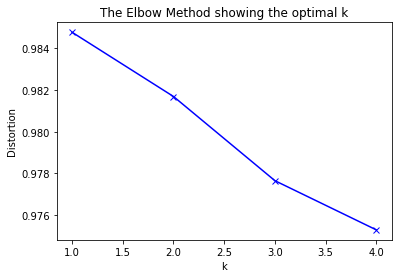

In [23]:
# make elbow plot, find k
distortions = []
k_list = range(1, 5)
for N in k_list:
    clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
    labels = clf.fit_predict(wordvector_fit)
    wordvector_fit_2d = wordvector_fit.todense()
    distortions.append(sum(np.min(cdist(wordvector_fit_2d, clf.cluster_centers_, 'euclidean'), axis=1)) / wordvector_fit_2d.shape[0])

# Plot the elbow
plt.plot(k_list, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


## K-Means Clustering Algorithm:

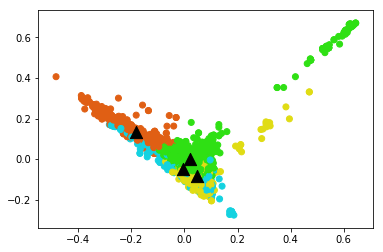

In [24]:

N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

## Latent Dirichlet Allocation:

#### LDA is useful here for us to find latent manifolds in text data. 
#### Here, we try to categorize all the data in to 10 topics, by choosing specific words and classifying them by comparing the difference between the weighs of those specific words. From the scores showing below, there are ten topics. 

In [25]:
#New LDA
text_clean=[]
for text in short_analysis['clean_content']:
    text_clean.append(text.split())
dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=10, id2word = dictionary, passes=30)
topics = ldamodel.print_topics(num_topics=10, num_words=10)
for i, j in enumerate(topics):
    print("Topic: {}\n{}\n".format(i, j))

Topic: 0
(0, '0.026*"sportsline" + 0.025*"fantasy" + 0.024*"href" + 0.024*"mp" + 0.023*"random" + 0.021*"football" + 0.020*"league" + 0.019*"owner" + 0.019*"script" + 0.018*"face"')

Topic: 1
(1, '0.026*"eric" + 0.018*"get" + 0.017*"know" + 0.015*"go" + 0.014*"would" + 0.011*"send" + 0.011*"like" + 0.009*"make" + 0.009*"want" + 0.009*"thank"')

Topic: 2
(2, '0.017*"game" + 0.009*"last" + 0.008*"ees" + 0.008*"play" + 0.008*"go" + 0.008*"get" + 0.007*"team" + 0.007*"say" + 0.006*"allow" + 0.006*"yards"')

Topic: 3
(3, '0.008*"new" + 0.007*"energy" + 0.006*"click" + 0.006*"research" + 0.006*"dec" + 0.006*"carrfut" + 0.005*"pdf" + 0.005*"free" + 0.005*"image" + 0.005*"html"')

Topic: 4
(4, '0.007*"e" + 0.007*"price" + 0.007*"trade" + 0.005*"power" + 0.004*"say" + 0.004*"would" + 0.004*"deal" + 0.004*"get" + 0.004*"service" + 0.004*"sell"')

Topic: 5
(5, '0.048*"right" + 0.039*"nbsp" + 0.027*"p" + 0.024*"span" + 0.023*"leave" + 0.016*"style" + 0.009*"susan" + 0.009*"text" + 0.008*"u" + 0.00

#### Obtaining these latent manifold is definitely a tool for us to improve our data mining becasue we can know how we will categorize the data, cleaning the data, and further more make predictions. By picking right topics here, our data can even be reduced so we can have better time complexity running the model.

## Gaussian Mixed Model (GMM):

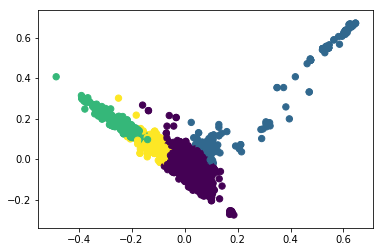

In [27]:

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(datapoint)
labels = gmm.predict(datapoint)
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels, s=40, cmap='viridis');